# DSAIT4335 Recommender Systems
# Assignment 2: Collaborative Filtering

In this assignment, you will work to build different recommendation models under Collaborative Filtering approach, including user-based and item-based neighborhood models, and matrix factorization. Then, you will apply these recommendation models on a public dataset. The dataset is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/.

By the end of this assignment, you will:
1. Understand the fundamental principles of collaborative filtering approach
2. Implement user-based and item-based neighborhood methods
3. Develop recommendation generation and prediction with SLIM and MF models
4. Perform both rating prediction and top-k recommendation tasks
5. Evaluate collaborative filtering methods to understand their strengths/limitations

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. 

**Expected file structure** for this assignment:   
   
   ```
   Assignment2/
   ├── training.txt
   ├── test.txt
   └── hw2.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your name: firstname-lastname.ipynb.

# Setup

Import necessary libraries/packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time, math
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


# 1) MovieLens100K dataset

Load the data files: training and test sets.

In [2]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')
# print(test_data.shape)

The training data:


,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


# 2) User-based collaborative filtering

### Question 1: Implement a function that computes the Pearson Correlation between two users. 

The **Pearson correlation coefficient** between two users \(x\) and \(y\) is defined as:

$$
r_{xy} = \frac{\sum_{i \in I_{xy}} (x_i - \bar{x})(y_i - \bar{y})}
              {\sqrt{\sum_{i \in I_{xy}} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i \in I_{xy}} (y_i - \bar{y})^2}}
$$

**Where:**

- $I_{xy}$ = set of items rated by both users  
- $x_i$, $y_i$ = ratings of users \(x\) and \(y\) on item \(i\)  
- $\bar{x}$, $\bar{y}$ = mean ratings of users \(x\) and \(y\) on the common items  


In [3]:
def pearson_correlation(user1_ratings: pd.Series, user2_ratings: pd.Series) -> float:
    """
    Compute Pearson correlation coefficient between two users' rating vectors.
    
    user1_ratings, user2_ratings: Pandas Series indexed by item IDs. They may contain NaN for unrated items.
    Returns: float (correlation between -1 and 1). Returns 0 if not enough data.
    """
    result = 0.0
    
    ############# Your code here ############
    concat = pd.concat([user1_ratings, user2_ratings], axis=1, keys=['u1', 'u2']).dropna()
    # Get items both have rated
    u1 = concat['u1']
    u2 = concat['u2']
    mean_x = np.mean(u1)
    mean_y = np.mean(u2)
    u1_normalized = u1 - mean_x
    u2_normalized = u2 - mean_y
    numerator = np.dot(u1_normalized, u2_normalized)
    
    denominator = np.sqrt(np.dot(u1_normalized, u1_normalized)) * np.sqrt(np.dot(u2_normalized, u2_normalized))
    if len(concat) < 2 or denominator == 0:
        return 0.0
        
    result = numerator / denominator
    #########################################
    
    return result

user1, user2 = 1, 2
user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
user2_ratings = train_data[train_data['user_id'] == user2].set_index('item_id')['rating']
print(f"Pearson Correlation between users {user1} and {user2} is {pearson_correlation(user1_ratings, user2_ratings):.4f}")

Pearson Correlation between users 1 and 2 is 0.2697


### Question 2: What is the similarity value between users <8,9>. Discuss your observation.

In [4]:
user1, user2 = 9, 8
sim = 0.0

############# Your code here ############
user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
user2_ratings = train_data[train_data['user_id'] == user2].set_index('item_id')['rating']
sim = pearson_correlation(user1_ratings, user2_ratings)
#########################################

print(f"Pearson Correlation between users {user1} and {user2} is {sim:.4f}")

Pearson Correlation between users 9 and 8 is 0.0000


The users have no items rated in common, thus their similarity is 0.

### Question 3: What is the similarity value between users <2,3>? Discuss your observation.

In [5]:
user1, user2 = 2, 3
sim = 0.0

############# Your code here ############
user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
user2_ratings = train_data[train_data['user_id'] == user2].set_index('item_id')['rating']
sim = pearson_correlation(user1_ratings, user2_ratings)
#########################################

print(f"Pearson Correlation between users {user1} and {user2} is {sim:.4f}")

Pearson Correlation between users 2 and 3 is 0.0000


This time users have rated items in common, however, for user 2 all ratings for these items are the same, thus in the normalization step by their mean rating, it becomes a zero vector, which leads to multiplications by zero, and in the end, a similarity of 0.

### Question 4: Create the user-user similarity matrix.

In [6]:
def compute_user_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute user-user similarity matrix using Pearson correlation.
    
    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: user-user similarity matrix (rows & cols = user_ids)
    """
    users = train_data['user_id'].unique()
    user_similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=users, columns=users)
    
    ############# Your code here ############
    for user1 in users:
        user1_ratings = train_data[train_data['user_id'] == user1].set_index('item_id')['rating']
        rating_lists = [train_data[train_data['user_id'] == user2].set_index('item_id')['rating'] for user2 in users] 
        similarities = [pearson_correlation(user1_ratings, user2_ratings) for user2_ratings in rating_lists]
        similarities[user1 - 1] = 0.0
        user_similarity_matrix[user1] = similarities
    #########################################
    
    return user_similarity_matrix

start_time = time.time()
print(f'Similarity matrix creation started! This may take around 5-10 minutes...')
user_similarity_matrix = compute_user_similarity_matrix(train_data)  
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Similarity matrix creation started! This may take around 5-10 minutes...
Running time: 474.5281 seconds


### Question 5: Implement a function that returns k most similar users along with the similarity values to a target user.

In [7]:
neighbours = {}

def get_k_user_neighbors(user_similarity_matrix: pd.DataFrame, target_user, k=5):
    """
    Retrieve top-k most similar users to the target user.

    Parameters:
    - user_similarity_matrix: pd.DataFrame, user-user similarity values (indexed by user IDs)
    - target_user: user ID for whom we want neighbors
    - k: number of neighbors to retrieve

    Returns:
    - List of tuples: [(neighbor_user_id, similarity), ...] sorted by similarity descending
    """
    top_k_neighbors = []
    
    ############# Your code here ############
    # if target_user not in neighbours: 
    #     sims = user_similarity_matrix.loc[:, target_user]
    
    #     # top-k most similar users
    #     top_k = sims.sort_values(ascending=False).head(k)
    #     top_k_users = top_k.index.values.tolist()
    #     top_k_sims = top_k.values.tolist()
    #     neighbours[target_user] = zip(top_k_users, top_k_sims)

    # top_k_neighbors = neighbours[target_user]
    sims = user_similarity_matrix.loc[:, target_user]
    
    # top-k most similar users
    top_k = sims.sort_values(ascending=False).head(k)
    top_k_users = top_k.index.values.tolist()
    top_k_sims = top_k.values.tolist()
    
    top_k_neighbors = zip(top_k_users, top_k_sims)
        
    #########################################
    return top_k_neighbors

target_user, k = 1, 10
print(f"Neighbors of user {target_user} are:")
get_k_user_neighbors(user_similarity_matrix, target_user, k)

Neighbors of user 1 are:


### Question 6: Implement a function that predicts the rating for a target user might give to a target item using user-user similarity matrix and the following equation.

The **predicted rating** for a target user \(u\) on item \(i\) using mean-centered user-based collaborative filtering is:

$$
\hat{r}_{u,i} = \bar{r}_u + \frac{\sum_{v \in N(u)} s(u,v) \cdot (r_{v,i} - \bar{r}_v)}
                             {\sum_{v \in N(u)} |s(u,v)|}
$$

Where:

- $\hat{r}_{u,i}$ = predicted rating for user \(u\) on item \(i\)  
- $\bar{r}_u$ = mean rating of the target user \(u\)  
- $N(u)$ = set of top-\(k\) neighbors of user \(u\) who have rated item \(i\)  
- $s(u,v)$ = similarity between users \(u\) and \(v\)  
- $r_{v,i}$ = rating of neighbor \(v\) on item \(i\)  
- $\bar{r}_v$ = mean rating of neighbor \(v\)


In [8]:
user_means = train_data.groupby('user_id')['rating'].mean()
ratings_si = train_data.set_index(['user_id', 'item_id'])['rating']  # Series with MultiIndex

In [9]:
import time

def predict_rating_user_based(train_data: pd.DataFrame, user_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating for target_user and target_item using mean-centered user-based CF.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    - user_similarity_matrix: pd.DataFrame of user-user similarities
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to consider

    Returns:
    - float: predicted rating, or np.nan if not possible
    """
    results = 0.0
    
    ############# Your code here ############
    mean_rating = user_means.get(target_user, float(train_data['rating'].mean()))
    user_ids = (train_data
                .loc[(((train_data['item_id'] == target_item) & (train_data['rating'].notna())) |
                      (train_data['user_id'] == target_user)), 'user_id']
                .unique())

    ids = pd.Index(user_ids).astype(user_similarity_matrix.index.dtype, copy=False)
    keep = user_similarity_matrix.index.intersection(ids)  
    S_small = user_similarity_matrix.loc[keep, keep].copy()
    Nu = get_k_user_neighbors(S_small, target_user, k)

    numerator = 0.0
    denominator = 0.0
    for v, sim in Nu:
        if v == target_user:
            continue
        user_mean_rating = np.mean(train_data.loc[((train_data['user_id'] == v) & (train_data['rating'].notna())), 'rating'])
        user_item_rating = train_data.loc[((train_data['user_id'] == v) & (train_data['item_id'] == target_item)), 'rating'].values[0]
        numerator += sim * (user_item_rating - user_mean_rating)
        denominator += np.abs(sim)
    # Prevent division by 0
    if denominator >= 1e-10:
        results = (numerator / denominator) + mean_rating
    else:
        results = mean_rating
    #########################################

    return results

target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by user-based CF for user {target_user} and item {target_item} is {predict_rating_user_based(train_data, user_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by user-based CF for user 1 and item 17 is 3.4832


### Question 7: Implement a function that generates top-10 recommendation list for a target user using user-based CF method.

In [10]:
def recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k=5):
    """
    Generate Top-K recommendations for a target user using User-based CF.
    
    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        target_user (int): user_id of the target user
        k (int): number of most similar neighbors to consider
    
    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []
    
    ############# Your code here ############
    items = train_data['item_id'].unique()
    predictions = [(item, predict_rating_user_based(train_data, user_similarity_matrix, target_user, item, k)) for item in items]
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    result = sorted_predictions[:k]
    #########################################
    
    return result

start_time = time.time()
target_user, k = 1, 30
recommendations = recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Top-10 recommendations for user 1:
Item 1290: 5.9537
Item 1354: 5.8394
Item 1678: 5.8030
Item 1368: 5.2213
Item 1467: 5.1903
Item 1599: 5.1101
Item 910: 5.0853
Item 1293: 4.9567
Item 1639: 4.9344
Item 1642: 4.9321
Item 1414: 4.9060
Item 1500: 4.8958
Item 12: 4.8365
Item 1673: 4.8285
Item 1680: 4.8030
Item 313: 4.7801
Item 853: 4.7759
Item 913: 4.7735
Item 1636: 4.7735
Item 1645: 4.7735
Item 1650: 4.7735
Item 1651: 4.7735
Item 172: 4.7734
Item 793: 4.7724
Item 408: 4.7660
Item 867: 4.7578
Item 1656: 4.7561
Item 1449: 4.7286
Item 1585: 4.7221
Item 1391: 4.7185
Running time: 9.6795 seconds


# 3) Item-based collaborative filtering

### Question 8: Implement a function that computes the Cosine similarity between two items. 

The **cosine similarity** between two items \(i\) and \(j\) is defined as:

$$
\text{sim}(i,j) = \frac{\sum_{u \in U_{ij}} r_{u,i} \cdot r_{u,j}}
                      {\sqrt{\sum_{u \in U_{ij}} r_{u,i}^2} \cdot \sqrt{\sum_{u \in U_{ij}} r_{u,j}^2}}
$$

Where:

- \(r_{u,i}\) = rating of user \(u\) on item \(i\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  
- \(U_{ij}\) = set of users who have rated both items \(i\) and \(j\)  


In [11]:
def cosine_similarity(item1_ratings: pd.Series, item2_ratings: pd.Series) -> float:
    """
    Compute cosine similarity between two items' rating vectors.
    Only common users are considered.
    
    Parameters:
    - item1_ratings, item2_ratings: pd.Series indexed by user_id
    
    Returns:
    - float: cosine similarity between -1 and 1
    """
    result = 0.0
    
    ############# Your code here ############
    concat = pd.concat([item1_ratings, item2_ratings], axis=1, keys=['i1', 'i2']).dropna()
    i1 = concat['i1']
    i2 = concat['i2']
    numerator = np.dot(i1, i2)
    denominator = np.sqrt(np.dot(i1, i1)) * np.sqrt(np.dot(i2, i2))
    if (denominator >= 0.0000000001):
        result = numerator / denominator
    else:
        result = 0
    #########################################

    return result

item1, item2 = 1, 2
item1_ratings = train_data[train_data['item_id'] == item1].set_index('user_id')['rating']
item2_ratings = train_data[train_data['item_id'] == item2].set_index('user_id')['rating']
print(f"Cosine similarity between items {item1} and {item2} is {cosine_similarity(item1_ratings, item2_ratings):.4f}")

Cosine similarity between items 1 and 2 is 0.9500


### Question 9: Create the item-item similarity matrix.

In [12]:
def compute_item_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute item-item similarity matrix using cosine similarity.
    
    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    
    Returns:
    - pd.DataFrame: item-item similarity matrix (rows & cols = item_ids)
    """
    items = train_data['item_id'].unique()
    item_similarity_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)
    
    ############# Your code here ############
    by_item = {iid: grp.set_index('user_id')['rating'] for iid, grp in train_data.groupby('item_id')}

    # Use a fixed item order (matches your preallocated matrix labels)
    item_list = list(item_similarity_matrix.index)
    
    # Fill only the upper triangle and mirror it (half the work)
    for i, item1 in enumerate(item_list):
        item_similarity_matrix.loc[item1, item1] = 0.0  # no self-recommendation
        r1 = by_item[item1]
        for j in range(i + 1, len(item_list)):
            item2 = item_list[j]
            r2 = by_item[item2]
            s = cosine_similarity(r1, r2)
            item_similarity_matrix.loc[item1, item2] = s
            item_similarity_matrix.loc[item2, item1] = s
    #########################################
    
    return item_similarity_matrix

start_time = time.time()
item_similarity_matrix = compute_item_similarity_matrix(train_data)  
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Running time: 526.6974 seconds


### Question 10: Implement a function that returns k most similar item along with the similarity values to a target item.

In [13]:
def get_k_item_neighbors(item_similarity_matrix: pd.DataFrame, target_item, k=5):
    """
    Retrieve top-k most similar items to the target item.
    
    Parameters:
    - item_similarity_matrix: pd.DataFrame, item-item similarity
    - target_item: item ID
    - k: number of neighbors
    
    Returns:
    - List of tuples: [(neighbor_item_id, similarity), ...]
    """
    top_k_neighbors = []

    ############# Your code here ############
    if (target_item not in item_similarity_matrix.columns
        and target_item not in item_similarity_matrix.index):
        return []
        
    sims = item_similarity_matrix.loc[:, target_item]
    sims = sims.drop(target_item, errors='ignore')

    # top-k most similar users
    top_k = sims.sort_values(ascending=False).head(k)
    top_k_items = top_k.index.values.tolist()
    top_k_sims = top_k.values.tolist()
    top_k_neighbors = zip(top_k_items, top_k_sims)
    #########################################
    
    return top_k_neighbors

target_item, k = 1, 10
print(f"Neighbors of item {target_item} are:")
get_k_item_neighbors(item_similarity_matrix, target_item, k)

Neighbors of item 1 are:


### Question 11: Implement a function that predicts the rating for a target user might give to a target item using item-item similarity matrix and the following equation.

The **predicted rating** for a target user \(u\) on a target item \(i\) using item-based collaborative filtering is:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} s(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} |s(i,j)|}
$$

Where:

- \(\hat{r}_{u,i}\) = predicted rating of user \(u\) on item \(i\)  
- \(N(i)\) = set of top-\(k\) most similar items to item \(i\) that user \(u\) has rated  
- \(s(i,j)\) = similarity between item \(i\) and item \(j\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  


In [14]:
def predict_rating_item_based(train_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating using item-based CF (non-mean centric).
    
    Parameters:
    - ratings: pd.DataFrame ['user_id', 'item_id', 'rating']
    - item_similarity_matrix: item-item similarity DataFrame
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to use
    
    Returns:
    - float: predicted rating, or np.nan if not enough data
    """
    result = 0.0

    ############# Your code here ############
    item_ids = (train_data
            .loc[(((train_data['user_id'] == target_user) & (train_data['rating'].notna())) | (train_data['item_id'] == target_item)), 'item_id']
            .unique())
    ids = pd.Index(item_ids).astype(item_similarity_matrix.index.dtype, copy=False)
    keep = item_similarity_matrix.index.intersection(ids)  
    S_small = item_similarity_matrix.loc[keep, keep].copy()
    Ni = get_k_item_neighbors(S_small, target_item, k)
    sims = []
    js = []
    for j, sim in Ni:
        if j == target_item:
            continue
        sims.append(sim)
        js.append(j)
    ratings = []
    for j in js:
        # print(f"item: {j}, target: {target_item}")
        # print(f"ratings: {train_data.loc[((train_data['user_id'] == target_user) & (train_data['item_id'] == j)), 'rating']}")
        rating = train_data.loc[((train_data['user_id'] == target_user) & (train_data['item_id'] == j)), 'rating'].values[0] 
        ratings.append(rating)
    numerator = np.dot(sims, ratings)
    denominator = np.sum(np.abs(sims))
    
    epsilon = 0.000001
    if denominator >= epsilon or denominator <= -epsilon:
        result = numerator / denominator
    else:
        result = 0.0
    #########################################
    
    return result

target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by item-based CF for user {target_user} and item {target_item} is {predict_rating_item_based(train_data, item_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by item-based CF for user 1 and item 17 is 3.5321


### Question 12: Implement a function that generates top-10 recommendation list for a target user using item-based CF method.

In [15]:
def recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k=5):
    """
    Generate Top-K recommendations for a target user using Item-based CF.
    
    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend
    
    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    ############# Your code here ############
    items = train_data['item_id'].unique()
    predictions = [(item, predict_rating_item_based(train_data, item_similarity_matrix, target_user, item, k)) for item in items]
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    result = sorted_predictions[:k]
    #########################################
    
    return result

target_user, k = 1, 50
recommendations = recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k)
print(f"Top-10 recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-10 recommendations for user 1:
Item 1342: 5.0000
Item 1414: 4.7500
Item 1259: 4.5332
Item 1354: 4.5000
Item 1654: 4.4375
Item 1618: 4.4000
Item 1500: 4.4000
Item 127: 4.3803
Item 55: 4.3599
Item 89: 4.3593
Item 198: 4.3571
Item 1332: 4.3529
Item 1234: 4.3481
Item 223: 4.3372
Item 1347: 4.3276
Item 191: 4.2787
Item 868: 4.2604
Item 111: 4.2593
Item 70: 4.2585
Item 194: 4.2560
Item 1674: 4.2500
Item 1678: 4.2500
Item 1679: 4.2500
Item 1680: 4.2500
Item 195: 4.2393
Item 28: 4.2378
Item 87: 4.2376
Item 178: 4.2351
Item 207: 4.2292
Item 1597: 4.2205
Item 1447: 4.2200
Item 1450: 4.2200
Item 1452: 4.2200
Item 1453: 4.2200
Item 1460: 4.2200
Item 1461: 4.2200
Item 270: 4.2179
Item 1360: 4.2069
Item 1593: 4.2069
Item 50: 4.2027
Item 1677: 4.2000
Item 174: 4.1993
Item 1: 4.1986
Item 269: 4.1985
Item 64: 4.1975
Item 13: 4.1961
Item 172: 4.1819
Item 177: 4.1802
Item 1656: 4.1800
Item 357: 4.1797


# 3) Matrix Factorization (MF)

For details about matrix factorization algorithm see the lecture in week 3.

Matrix factorization algorithm is implemented in the next cell. Run the following cell and then use it to build MF model for running experiments.

In [ ]:
class MatrixFactorizationSGD:
    """
    Matrix Factorization for rating prediction using Stochastic Gradient Descent (SGD).
    
    Rating matrix R ≈ P × Q^T + biases
    """
    def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, use_bias=True):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.use_bias = use_bias

        # Model parameters
        self.P = None  # User latent factors
        self.Q = None  # Item latent factors
        self.user_bias = None
        self.item_bias = None
        self.global_mean = None

    def fit(self, ratings, verbose=True):
        """
        Train the model.
        
        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating]
        """
        # Map IDs to indices
        self.user_mapping = {u: i for i, u in enumerate(ratings['user_id'].unique())}
        self.item_mapping = {i: j for j, i in enumerate(ratings['item_id'].unique())}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}

        n_users = len(self.user_mapping)
        n_items = len(self.item_mapping)

        # Initialize factors
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, self.n_factors))

        if self.use_bias:
            self.user_bias = np.zeros(n_users)
            self.item_bias = np.zeros(n_items)
            self.global_mean = ratings['rating'].mean()

        # Convert to (user_idx, item_idx, rating) triples
        training_data = [(self.user_mapping[u], self.item_mapping[i], r)
                         for u, i, r in zip(ratings['user_id'], ratings['item_id'], ratings['rating'])]

        # SGD loop
        for epoch in range(self.n_epochs):
            np.random.shuffle(training_data)
            total_error = 0

            for u, i, r in training_data:
                pred = np.dot(self.P[u], self.Q[i])
                if self.use_bias:
                    pred += self.global_mean + self.user_bias[u] + self.item_bias[i]

                err = r - pred
                total_error += err ** 2

                # Updates
                P_u = self.P[u]
                Q_i = self.Q[i]

                self.P[u] += self.learning_rate * (err * Q_i - self.regularization * P_u)
                self.Q[i] += self.learning_rate * (err * P_u - self.regularization * Q_i)

                if self.use_bias:
                    self.user_bias[u] += self.learning_rate * (err - self.regularization * self.user_bias[u])
                    self.item_bias[i] += self.learning_rate * (err - self.regularization * self.item_bias[i])

            rmse = np.sqrt(total_error / len(training_data))
            if verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs} - RMSE: {rmse:.4f}")

        return self

    def predict_single(self, user_id, item_id):
        """Predict rating for a single (user, item) pair"""
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return np.nan

        u = self.user_mapping[user_id]
        i = self.item_mapping[item_id]

        pred = np.dot(self.P[u], self.Q[i])
        if self.use_bias:
            pred += self.global_mean + self.user_bias[u] + self.item_bias[i]
        return pred

    def predict(self, test_data):
        """Predict ratings for a test dataframe with [user_id, item_id]"""
        preds = []
        for u, i in zip(test_data['user_id'], test_data['item_id']):
            preds.append(self.predict_single(u, i))
        return np.array(preds)

    def recommend_topk(self, user_id, train_data, n=10, exclude_seen=True):
        """
        Generate Top-K recommendations for a given user.

        Args:
            user_id (int): target user ID (original ID, not index).
            train_data (pd.DataFrame): training ratings [user_id, item_id, rating],
                                       used to exclude already-seen items.
            k (int): number of recommendations.
            exclude_seen (bool): whether to exclude items the user already rated.

        Returns:
            list of (item_id, predicted_score) sorted by score desc.
        """
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]

        # Predict scores for all items
        scores = np.dot(self.P[u], self.Q.T)
        if self.use_bias:
            scores += self.global_mean + self.user_bias[u] + self.item_bias

        # Exclude seen items
        if exclude_seen:
            seen_items = train_data[train_data['user_id'] == user_id]['item_id'].values
            seen_idx = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[seen_idx] = -np.inf

        # Get top-K items
        top_idx = np.argsort(scores)[::-1][:n]
        top_items = [self.item_inv[i] for i in top_idx]
        top_scores = scores[top_idx]

        return list(zip(top_items, top_scores))

#### Sample usage for rating prediction task:

In [17]:
# Train model 
# Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
mf = MatrixFactorizationSGD(n_factors=50, n_epochs=10, learning_rate=0.001, regularization=0.001)
mf.fit(train_data, verbose=True)

# predict the rating for a target user and a target item
target_user = 1
target_item = 17
actual_rating = 3
pred_rating = mf.predict_single(target_user, target_item)
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by MF for user {target_user} and item {target_item} is {pred_rating:.4f}")

Epoch 1/10 - RMSE: 1.0965
Epoch 2/10 - RMSE: 1.0573
Epoch 3/10 - RMSE: 1.0312
Epoch 4/10 - RMSE: 1.0125
Epoch 5/10 - RMSE: 0.9984
Epoch 6/10 - RMSE: 0.9873
Epoch 7/10 - RMSE: 0.9783
Epoch 8/10 - RMSE: 0.9708
Epoch 9/10 - RMSE: 0.9645
Epoch 10/10 - RMSE: 0.9590
The actual rating for user 1 and item 17 is 3. The predicted rating by MF for user 1 and item 17 is 3.4983


#### Sample usage for ranking task:

In [18]:
# Train model 
# Parameters: n_factors refers to embedding size, n_epochs refers to number of epochs, learning_rate refers to learning rate, and regularization refers to lambda hyperparameter controlling the effect of regularization terms
mf = MatrixFactorizationSGD(n_factors=10, n_epochs=10, learning_rate=0.001, regularization=0.001)
mf.fit(train_data, verbose=True)

# Get top-10 recommendations for user 1
recommendations = mf.recommend_topk(user_id=1, train_data=train_data, n=10)
print("Top-10 Recommendations for user 1:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Epoch 1/10 - RMSE: 1.0944
Epoch 2/10 - RMSE: 1.0560
Epoch 3/10 - RMSE: 1.0306
Epoch 4/10 - RMSE: 1.0126
Epoch 5/10 - RMSE: 0.9992
Epoch 6/10 - RMSE: 0.9889
Epoch 7/10 - RMSE: 0.9806
Epoch 8/10 - RMSE: 0.9738
Epoch 9/10 - RMSE: 0.9682
Epoch 10/10 - RMSE: 0.9634
Top-10 Recommendations for user 1:
Item 64: 4.4136
Item 483: 4.4110
Item 318: 4.3957
Item 12: 4.3777
Item 313: 4.3221
Item 98: 4.2959
Item 427: 4.2894
Item 357: 4.2575
Item 603: 4.2419
Item 174: 4.2418


# 4) Evaluation of user-based, item-based, and MF models for rating prediction task

### Question 13: What is the performance of user-based CF in terms of RMSE for k=50?

In [19]:
from sklearn.metrics import mean_squared_error

def RMSE(ground_truth: [float], predictions: [float]) -> float:
    return mean_squared_error(ground_truth, predictions)

In [20]:
def evaluate_user_cf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, user_similarity_matrix: pd.DataFrame, k=5) -> float:
    """
    Evaluate user-based CF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - user_similarity_matrix: user-user similarity matrix (computed from train set)
    - k: number of neighbors
    
    Returns:
    - float: RMSE value
    """
    result = 0.0

    ############# Your code here ############
    start_time = time.time()
    predicted = test_data[['user_id', 'item_id']].apply(lambda x : predict_rating_user_based(train_data, user_similarity_matrix, x['user_id'], x['item_id'], k), axis=1).values
    end_time = time.time()
    gt = test_data['rating'].values
    rmse = RMSE(gt, predicted)
    result = rmse
    #########################################

    return result

k = 50
start_time = time.time()
print(f"RMSE of user-based CF for k={k} is {evaluate_user_cf_rating_prediction(train_data, test_data, user_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

RMSE of user-based CF for k=50 is 0.9361
Running time: 264.8241 seconds


### Question 14: Can you further improve the performance of user-based CF? Tune user-based CF with k={10, 30, 50, 70, 100} and visualize the performance with k values in x-axis and corresponding RMSE values in y-axis.

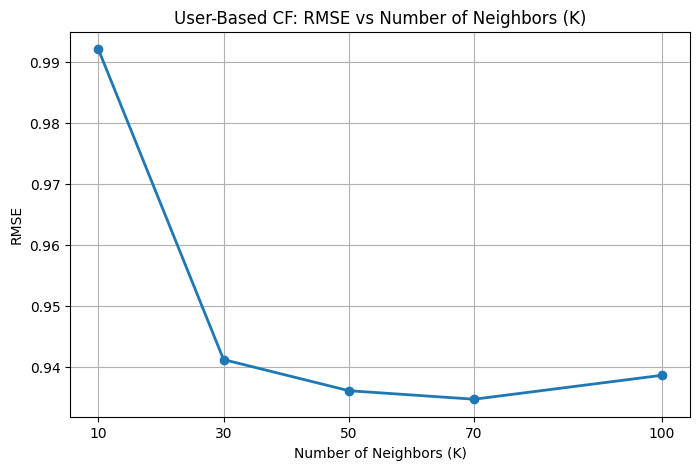

Running time: 1314.8316 seconds


In [21]:
K = [10,30,50,70,100]
user_based_RMSEs = []

start_time = time.time()

############# Your code here ############
user_based_RMSEs = [evaluate_user_cf_rating_prediction(train_data, test_data, user_similarity_matrix, k) for k in K]

plt.figure(figsize=(8, 5))
plt.plot(K, user_based_RMSEs, marker='o', linestyle='-', linewidth=2)
plt.title("User-Based CF: RMSE vs Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(K)
plt.show()
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Discuss your observations.

From the graph we see that first as the number of neighbors considered increases, the error gets smaller. I hypothesize this to be because the amount of information that can be taken from more neighbors increases. However, when K reaches a certain point, the error increases slightly again, possibly indicating that irrelevant information is added from the added neighbors (they are not similar enough to the user).

### Question 15: What is the performance of item-based CF in terms of RMSE for k=50?

In [22]:
def evaluate_item_cf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, k=5) -> float:
    """
    Evaluate item-based CF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - item_similarity_matrix: item-item similarity matrix (computed from train set)
    - k: number of neighbors
    
    Returns:
    - float: RMSE value
    """
    result = 0.0

    ############# Your code here ############
    predicted = test_data[['user_id', 'item_id']].apply(lambda x : predict_rating_item_based(train_data, item_similarity_matrix, x['user_id'], x['item_id'], k), axis=1).values
    gt = test_data['rating'].values
    rmse = RMSE(gt, predicted)
    result = rmse
    #########################################

    return result

k = 50
start_time = time.time()
print(f"RMSE of user-based CF for k={k} is {evaluate_item_cf_rating_prediction(train_data, test_data, item_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

RMSE of user-based CF for k=50 is 1.1004
Running time: 118.0783 seconds


### Question 16: Can you further improve the performance of item-based CF? Tune item-based CF with k={10, 30, 50, 70, 100} and visualize the performance with k values in x-axis and corresponding RMSE values in y-axis.

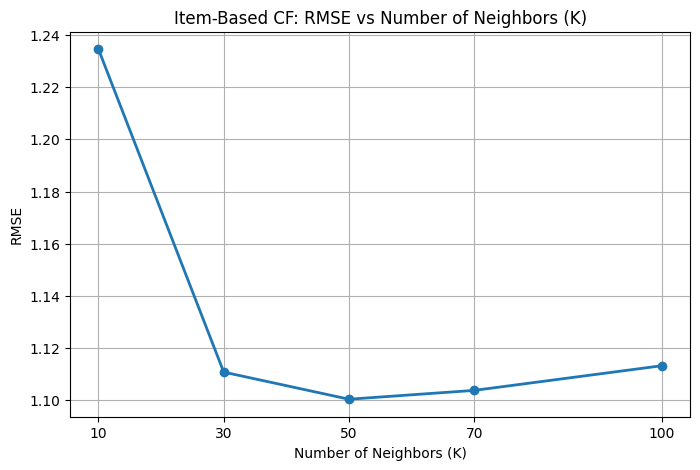

Running time: 635.6537 seconds


In [23]:
K = [10,30,50,70,100]
item_based_RMSEs = []

start_time = time.time()

############# Your code here ############
item_based_RMSEs = [evaluate_item_cf_rating_prediction(train_data, test_data, item_similarity_matrix, k) for k in K]

plt.figure(figsize=(8, 5))
plt.plot(K, item_based_RMSEs, marker='o', linestyle='-', linewidth=2)
plt.title("Item-Based CF: RMSE vs Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(K)
plt.show()   
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Discuss your observations.

Here we see a similar pattern as user-based CF, the only difference being that it is about the amount of item neighbors instead of user neighbors.

### Question 17: What is the performance of MF model in terms of RMSE for the following hyperparameter values?

    n_factors=50

    n_epochs=30

    learning_rate=0.001

    regularization=0.001

In [24]:
import math

def evaluate_mf_rating_prediction(train_data: pd.DataFrame, test_data: pd.DataFrame, n_factors: float, n_epochs: float, learning_rate: float) -> float:
    """
    Evaluate MF using RMSE on a test set.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - n_factors: embedding size
    - n_epochs: number of training epochs
    - learning_rate: Learning rate
    
    Returns:
    - float: RMSE value
    """
    # Hint: set the regularization hyperparameter to 0.001

    result = 0.0

    ############# Your code here ############
    mf = MatrixFactorizationSGD(n_factors=n_factors, n_epochs=n_epochs, learning_rate=learning_rate, regularization=0.001)
    mf.fit(train_data, verbose=False)
    predictions = mf.predict(test_data)
    # Filter for NaN predictions
    predictions = [p if not math.isnan(p) else 0.0 for p in predictions]
    gt = test_data['rating'].values
    rmse = RMSE(gt, predictions)
    result = rmse
    #########################################
    
    return result

n_factors, n_epochs, learning_rate = 50, 30, 0.001
start_time = time.time()
print(f"RMSE of MF for n_factors={n_factors}, n_epochs={n_epochs}, learning_rate={learning_rate} is {evaluate_mf_rating_prediction(train_data, test_data, n_factors, n_epochs, learning_rate):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

RMSE of MF for n_factors=50, n_epochs=30, learning_rate=0.001 is 0.9531
Running time: 11.5268 seconds


### Question 18: Tune MF model with n_factors={10, 30, 50, 70, 90} and the rest of hyperparameters as n_epochs=30, learning_rate=0.001. Visualize the performance with n_factors in x-axis and corresponding RMSE values in y-axis.

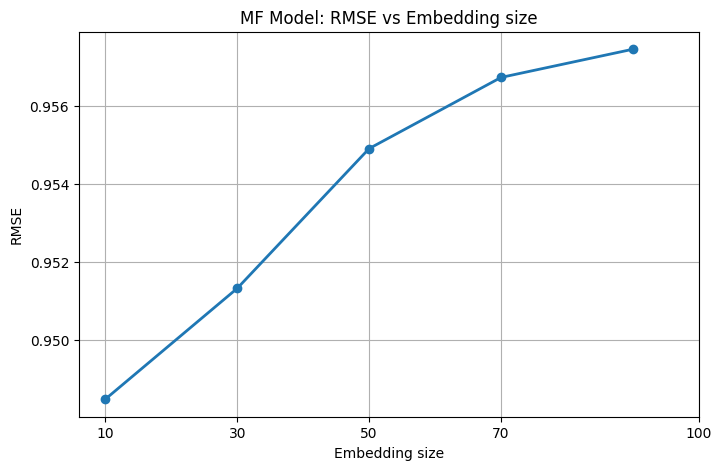

Running time: 57.0309 seconds


In [25]:
n_factors = [10,30,50,70,90]
n_epochs, learning_rate = 30, 0.001
mf_RMSEs = []

start_time = time.time()

############# Your code here ############
mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, i, n_epochs, learning_rate) for i in n_factors]

plt.figure(figsize=(8, 5))
plt.plot(n_factors, mf_RMSEs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: RMSE vs Embedding size")
plt.xlabel("Embedding size")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(K)
plt.show()       
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Discuss your observation.

We see that as the embedding size increases, the error does too. I think this is because a smaller embedding likely contains less irrelevant information. However, it is typically more complex to accurately compress high-dimensional information into a low-dimensional vector.

### Question 19: Tune MF model with n_epochs={10, 30, 50, 70, 90} and the rest of hyperparameters as n_factors=10, learning_rate=0.001. Visualize the performance with n_factors in x-axis and corresponding RMSE values in y-axis.

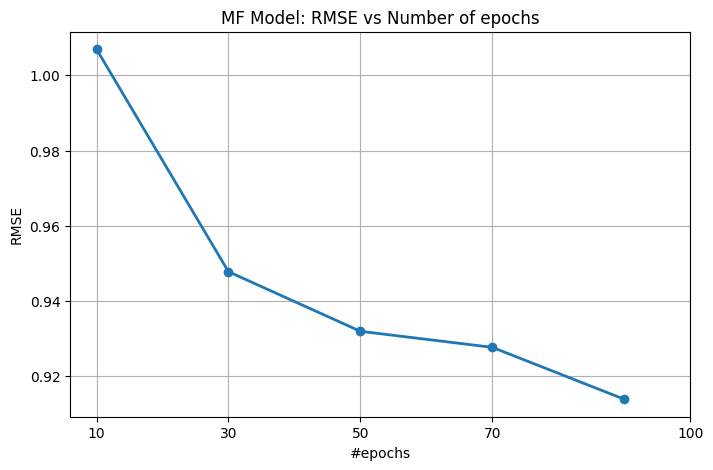

Running time: 92.7443 seconds


In [26]:
n_epochs = [10,30,50,70,90]
n_factors, learning_rate = 10, 0.001
mf_RMSEs = []

start_time = time.time()

############# Your code here ############
mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, n_factors, i, learning_rate) for i in n_epochs]

plt.figure(figsize=(8, 5))
plt.plot(n_epochs, mf_RMSEs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: RMSE vs Number of epochs")
plt.xlabel("#epochs")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(K)
plt.show()       
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Discuss your observation.

We see that when the number of epochs increases, the error decreases. When the model is trained for more epochs, it gets better at predicting ratings, up until a certain point.

### Question 20: Tune MF model with learning_rate={0.001, 0.005, 0.01, 0.05} and the rest of hyperparameters as n_factors=10, n_epochs=90. Visualize the performance with n_factors in x-axis and corresponding RMSE values in y-axis.

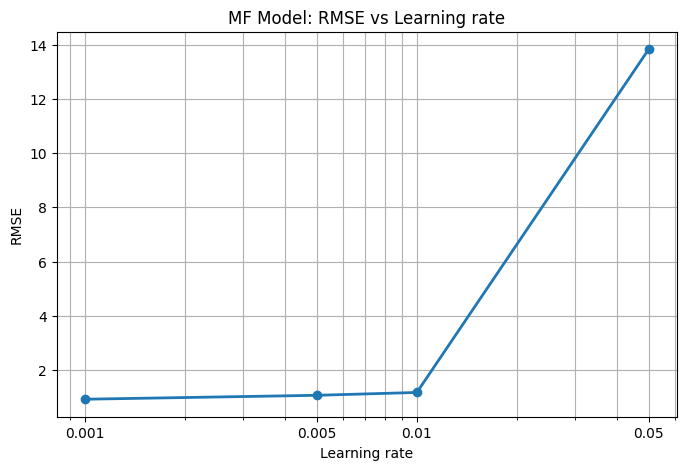

Running time: 134.0626 seconds


In [27]:
learning_rate = [0.001,0.005,0.01,0.05]
n_factors, n_epochs = 10, 90
mf_RMSEs = []

start_time = time.time()

############# Your code here ############
mf_RMSEs = [evaluate_mf_rating_prediction(train_data, test_data, n_factors, n_epochs, i) for i in learning_rate]
plt.figure(figsize=(8, 5))
plt.plot(learning_rate, mf_RMSEs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: RMSE vs Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("RMSE")
plt.grid(True, which='both')
plt.xscale('log')        # <-- makes x-axis spaced evenly in log scale
plt.xticks(learning_rate, labels=[str(lr) for lr in learning_rate])
plt.show()         
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

Discuss your observation.

I had to plot the learning rate on a log-scale to space the data out evenly. We see only a small difference in RMSE when looking at 0.001 v.s. 0.005 for example, but a very large difference in error when looking at 0.01 v.s. 0.05, even though both differ by a factor of 5. A higher learning rate means that the model trains more quickly, but we also see that it can drastically affect the RMSE. Therefore, there is a trade-off between how fast the model trains and how well it performs, similar to the number of epochs.

# 6) Evaluation of user-based, item-based, and MF models for ranking task

### Question 21: What is the performance of user-based CF in terms of nDCG for k=30?

In [30]:
gt_ranking = None

def NDCG(ground_truth, rec_list):
    # Implement a function that computes NDCG across ground truth data and recommendation list generated for each user. 
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.
    
    result = 0.0
    
    ############# Your code here ############
    # For each user calculate NDCG and take mean
    for gt_items, rec_items in zip(ground_truth, rec_list):
        K = len(rec_items)
        # Calculate DCG
        DCG = 0
        for i in range(K):
            numerator = 1 if rec_items[i] in gt_items else 0 
            denominator = np.log2(i + 2)
            DCG += numerator / denominator
        # IDCG (ideal is all relevant items up to K)
        ideal_len = min(K, len(gt_items))
        if ideal_len == 0:
            ndcg = 0.0
        else:
            IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
            ndcg = DCG / IDCG
        # Calculate NDCG
        result += ndcg
        
    # Take mean over all users
    result /= float(len(ground_truth))
    
    #########################################
    
    return result

def get_gt_ranking(test_data) -> [int]:
    if gt_ranking is not None:
        return gt_ranking

    gts = []
    
    user_ids = test_data['user_id'].unique().tolist()
    for user_id in user_ids:
        ratings = test_data[test_data['user_id'] == user_id].set_index('item_id')['rating']
        gt_ratings = ratings.sort_values(ascending=False).head(k)
        gt = gt_ratings.index.values.tolist()
        gts.append(gt)

    return gts

In [39]:
ps = []

def evaluate_user_cf_ranking(train_data, test_data, user_similarity_matrix, k=5):
    """
    Evaluate User-based CF ranking performance using NDCG@K.
    
    Args:
        train_data (pd.DataFrame): training ratings [user_id, item_id, rating]
        test_data (pd.DataFrame): test ratings [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        k (int): number of neighbors for prediction
    
    Returns:
        float: average NDCG@K across test users
    """
    result = 0.0

    ############# Your code here ############
    gts = get_gt_ranking(test_data)
    preds = []
    for user_id in test_data['user_id'].unique():
        pred = recommend_topk_user_based(train_data, user_similarity_matrix, user_id, k)
        pred_items = [item_id for item_id, _ in pred]
        preds.append(pred_items) # item id 
    ps = preds
    ndcg = NDCG(gts, preds)

    result = ndcg
    #########################################
    
    return result

k = 30
start_time = time.time()
print(f"NDCG of user-based CF for k={k} is {evaluate_user_cf_ranking(train_data, test_data, user_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

NDCG of user-based CF for k=30 is 0.0025
Running time: 6861.7949 seconds


### Question 22: What is the performance of item-based CF in terms of nDCG for k=30?

In [40]:
def evaluate_item_cf_ranking(train_data, test_data, item_similarity_matrix, k=5):
    """
    Evaluate Item-based CF ranking performance using NDCG@K.
    
    Args:
        train_data (pd.DataFrame): training ratings [user_id, item_id, rating]
        test_data (pd.DataFrame): test ratings [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        k (int): number of neighbors for prediction
    
    Returns:
        float: average NDCG@K across test users
    """
    result = 0.0

    ############# Your code here ############
    gts = get_gt_ranking(test_data)
    preds = []
    for user_id in test_data['user_id'].unique():
        pred = recommend_topk_item_based(train_data, user_similarity_matrix, user_id, k)
        pred_items = [item_id for item_id, _ in pred]
        preds.append(pred_items) # item id 
    ps = preds
    ndcg = NDCG(gts, preds)

    result = ndcg
    #########################################
    
    return result

k = 30
start_time = time.time()
print(f"NDCG of item-based CF for k={k} is {evaluate_item_cf_ranking(train_data, test_data, item_similarity_matrix, k):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

NDCG of item-based CF for k=30 is 0.0309
Running time: 2035.3396 seconds


### Question 23: What is the performance of MF model in terms of NDCG for the following hyperparameter values?

    n_factors=50

    n_epochs=30

    learning_rate=0.001

    regularization=0.001

In [50]:
def evaluate_mf_ranking(train_data: pd.DataFrame, test_data: pd.DataFrame, n_factors: float, n_epochs: float, learning_rate: float) -> float:
    """
    Evaluate MF in terms of NDCG.
    
    Parameters:
    - train_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for training
    - test_data: pd.DataFrame with ['user_id', 'item_id', 'rating'] used for testing
    - n_factors: embedding size
    - n_epochs: number of training epochs
    - learning_rate: Learning rate
    
    Returns:
    - float: NDCG value
    """
    # Hint: set the regularization hyperparameter to 0.001

    result = 0.0

    ############# Your code here ############
    gts = get_gt_ranking(test_data)

    mf = MatrixFactorizationSGD(n_factors=n_factors, n_epochs=n_epochs, learning_rate=learning_rate, regularization=0.001)
    mf.fit(train_data, verbose=False)
    user_ids = test_data['user_id'].unique()
    k = 30
    preds = []
    for user_id in test_data['user_id'].unique():
        pred = mf.recommend_topk(user_id, train_data, k)
        pred_items = [item_id for item_id, _ in pred]
        preds.append(pred_items) # item id 
    ps = preds
    
    ndcg = NDCG(gts, preds)
    result = ndcg
    #########################################
    
    return result

n_factors, n_epochs, learning_rate = 50, 30, 0.001
start_time = time.time()
print(f"NDCG of MF for n_factors={n_factors}, n_epochs={n_epochs}, learning_rate={learning_rate} is {evaluate_mf_ranking(train_data, test_data, n_factors, n_epochs, learning_rate):.4f}")
end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

NDCG of MF for n_factors=50, n_epochs=30, learning_rate=0.001 is 0.1125
Running time: 10.9798 seconds


### Question 24: Tune MF model with n_factors={10, 30, 50, 70, 90} and the rest of hyperparameters as n_epochs=30, learning_rate=0.001. Visualize the performance with n_factors in x-axis and corresponding NDCG values in y-axis.

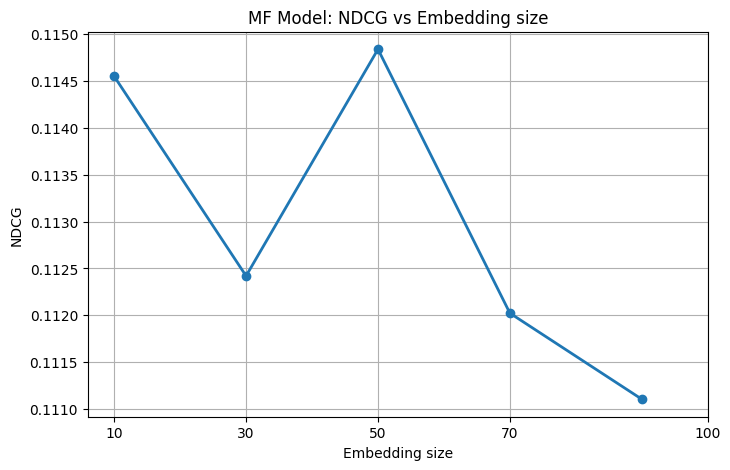

Running time: 58.1461 seconds


In [51]:
n_factors = [10,30,50,70,90]
n_epochs, learning_rate = 30, 0.001
mf_NDCGs = []

start_time = time.time()

############# Your code here ############
mf_NDCGs = [evaluate_mf_ranking(train_data, test_data, i, n_epochs, learning_rate) for i in n_factors]

plt.figure(figsize=(8, 5))
plt.plot(n_factors, mf_NDCGs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: NDCG vs Embedding size")
plt.xlabel("Embedding size")
plt.ylabel("NDCG")
plt.grid(True)
plt.xticks(K)
plt.show()      
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

### Question 25: Tune MF model with n_epochs={10, 30, 50, 70, 90} and the rest of hyperparameters as n_factors=30, learning_rate=0.001. Visualize the performance with n_factors in x-axis and corresponding NDCG values in y-axis.

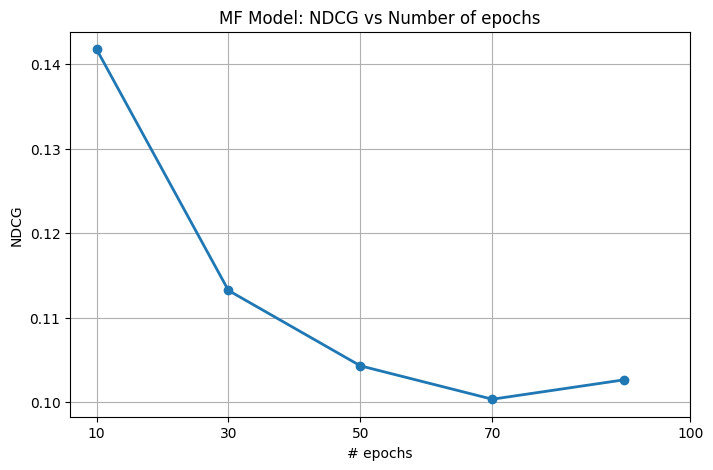

Running time: 97.4265 seconds


In [52]:
n_epochs = [10,30,50,70,90]
n_factors, learning_rate = 30, 0.001
mf_NDCGs = []

start_time = time.time()

############# Your code here ############
mf_NDCGs = [evaluate_mf_ranking(train_data, test_data, n_factors, i, learning_rate) for i in n_epochs]

plt.figure(figsize=(8, 5))
plt.plot(n_epochs, mf_NDCGs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: NDCG vs Number of epochs")
plt.xlabel("# epochs")
plt.ylabel("NDCG")
plt.grid(True)
plt.xticks(K)
plt.show()          
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

### Question 26: Tune MF model with learning_rate={0.001, 0.005, 0.01, 0.05} and the rest of hyperparameters as n_factors=10, n_epochs=90. Visualize the performance with n_factors in x-axis and corresponding NDCG values in y-axis.

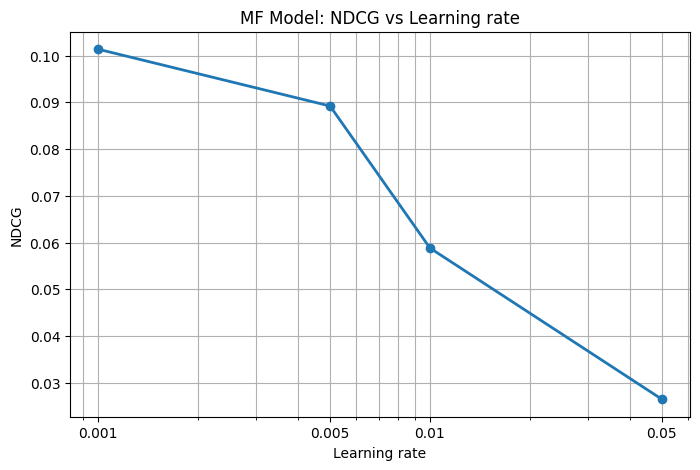

Running time: 135.4208 seconds


In [53]:
learning_rate = [0.001,0.005,0.01,0.05]
n_factors, n_epochs = 10, 90
mf_NDCGs = []

start_time = time.time()

############# Your code here ############
mf_NDCGs = [evaluate_mf_ranking(train_data, test_data, n_factors, n_epochs, i) for i in learning_rate]

plt.figure(figsize=(8, 5))
plt.plot(learning_rate, mf_NDCGs, marker='o', linestyle='-', linewidth=2)
plt.title("MF Model: NDCG vs Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("NDCG")
plt.grid(True, which='both')
plt.xscale('log')        # <-- makes x-axis spaced evenly in log scale
plt.xticks(learning_rate, labels=[str(lr) for lr in learning_rate])
plt.show()         
#########################################

end_time = time.time()
print(f'Running time: {end_time - start_time:.4f} seconds')

# 7) Discussion

### Question 27: Compare the performance of CF methods with the content-based recommendation model developed in assignment 1. Discuss your observations.

To compare the performance of the models we look at the RMSE for rating-prediction and the NDCG for Ranking-prediction, note that I picked the content-based variant with the lowest RMSE for the comparison.

<h2>Rating-prediction (k=50)</h2>
For the rating prediction we see that the User-Based CF and MF lead to a far lower error than the other 2. Furthermore, it is to be noted that the Matrix Factorization approach is a lot faster to evaluate than the other ones, probably due to how everything is implemented through pandas instead of numpy.
<table>
  <tr>
    <th>Model</th>
    <th>RMSE</th>
  </tr>
  <tr>
    <td>User-Based CF</td>
    <td>0.9361</td>
  </tr>
  <tr>
    <td>Item-Based CF</td>
    <td>1.1004</td>
  </tr>
  <tr>
    <td>MF</td>
    <td>0.9531</td>
  </tr>
  <tr>
    <td>Content-Based (type=full,average)</td>
    <td>1.21568</td>
  </tr>
</table>

<h2>Ranking-prediction (k=30)</h2>
When looking at the NDCG, we see that the MF algorithm leads to a higher score than the other CF approaches implemented in this assignment. Contrary to my expectations, we see that the Content-Based recommender has an NDCG score which is significantly better than the others. This is strange to me, as the error for rating prediction (which the ranking relies on) was the worst out of all algorithms. 

After looking at the code for the previous assignment, I see that the recommendation list there is of size 10 instead of 30, like the others in this assignment are. Due to the computational complexity of this assignment I will not recompute these values, and simply say that we cannot compare them like this.
<table>
  <tr>
    <th>Model</th>
    <th>NDCG</th>
  </tr>
  <tr>
    <td>User-Based CF</td>
    <td>0.0025</td>
  </tr>
  <tr>
    <td>Item-Based CF</td>
    <td>0.0309</td>
  </tr>
  <tr>
    <td>MF</td>
    <td>0.1125</td>
  </tr>
  <tr>
    <td>Content-Based (type=full,average)</td>
    <td>0.57789</td>
  </tr>
</table>